In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data

Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.columns = ['Sales']

In [4]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


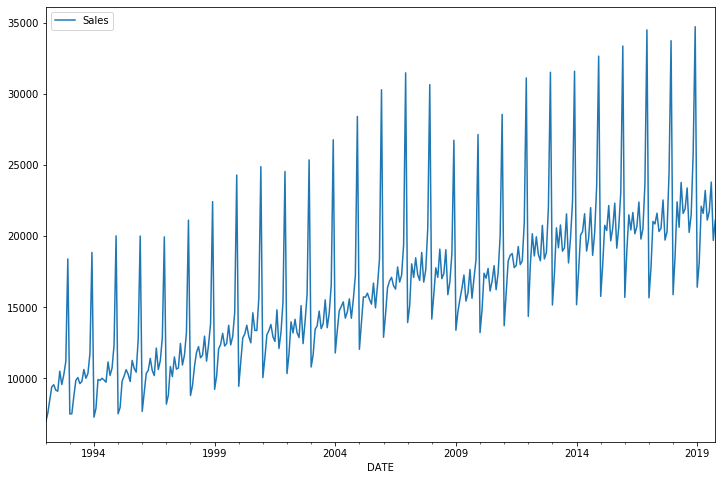

In [5]:
#plot Time Series
df.plot(figsize=(12,8))

In [6]:
#review len
len(df)

334

In [7]:
#test size must be enough to size get a full seasonal trends (18 months)
len(df) - 18

316

In [8]:
test_size = 18
test_ind = len(df) - test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
train.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [11]:
test.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


### Scale the data

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
scaled_train = scaler.transform(train)

In [16]:
scaled_test = scaler.transform(test)

### Time Series Generator
To produce batches for training/validation

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
#length must be less than test size, length 
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, 
                                length=length, batch_size=1)

In [19]:
X,y = generator[0]

In [20]:
#given 12 data points what will be the next data point
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [21]:
#predicting the next point
y

array([[0.02047633]])

In [22]:
#to check accuracy look for the data point after .41259723, see if it's close enough to the predicted y 
scaled_train

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633],
       [0.02127505],
       [0.06636654],
       [0.10633895],
       [0.11345484],
       [0.09791606],
       [0.10368864],
       [0.13396747],
       [0.11163956],
       [0.12372931],
       [0.17506535],
       [0.43250799],
       [0.0124165 ],
       [0.03499855],
       [0.10829945],
       [0.10641156],
       [0.11149434],
       [0.10728289],
       [0.10154662],
       [0.1531731 ],
       [0.11904589],
       [0.13767064],
       [0.19663085],
       [0.47480395],
       [0.02105722],
       [0.03714058],
       [0.10445106],
       [0.11726692],
       [0.13367703],
       [0.12209556],
       [0.10332559],
       [0.1570578 ],
       [0.13694453],
       [0.12710572],
       [0.21104415],
       [0.474

### Create the model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
#from tensorflow.keras.layers import LSTM

In [24]:
n_features = 1

In [25]:
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Early stopping and Validation generator

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [29]:
val_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=1)

In [30]:
model.fit_generator(generator,epochs=20,
                    validation_data=val_generator,
                   callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 304 steps, validate for 6 steps
Epoch 1/20
304/304 [==============================] - 5s 16ms/step - loss: 0.0271 - val_loss: 0.0203
Epoch 2/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0191 - val_loss: 0.0093
Epoch 3/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0146 - val_loss: 0.0020
Epoch 4/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0078 - val_loss: 0.0088
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0071 - val_loss: 0.0023


In [31]:
losses = pd.DataFrame(model.history.history)

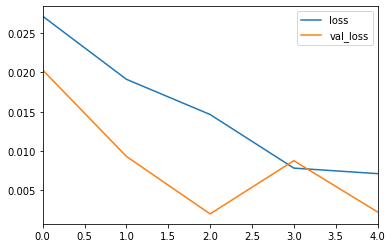

In [32]:
losses.plot()

### Validation and compare

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

In [35]:
test['Predictions'] = true_predictions

C:\Users\bnaoe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22113.097298
2018-06-01,21589,21384.043585
2018-07-01,21919,21621.705005
2018-08-01,23381,22925.226862
2018-09-01,20260,21239.336427
2018-10-01,21473,21776.382513
2018-11-01,25831,25077.614088
2018-12-01,34706,33236.482824
2019-01-01,16410,17851.485283


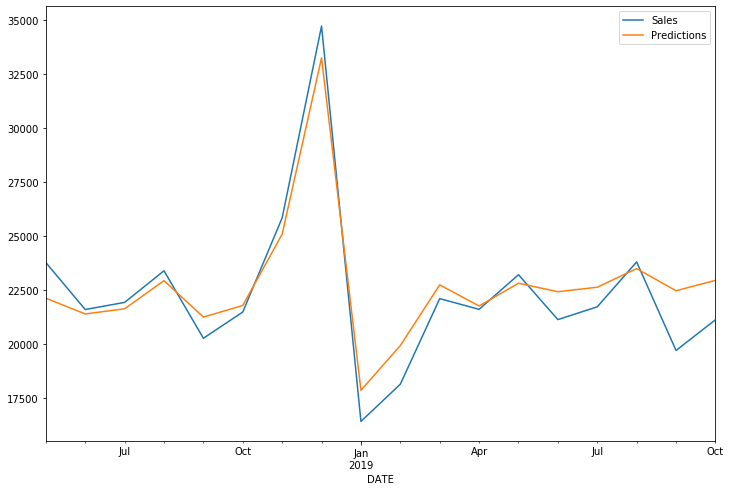

In [37]:
test.plot(figsize=(12,8))

### Full Train and forecasting

In [38]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [39]:
length = 12

generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length=length,batch_size=1)

In [40]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator,epochs=15)

  ...
    to  
  ['...']
Train for 322 steps
Epoch 1/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0252
Epoch 2/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0194
Epoch 3/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0101
Epoch 4/15
322/322 [==============================] - 2s 6ms/step - loss: 0.0048
Epoch 5/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0039
Epoch 6/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0042
Epoch 7/15
322/322 [==============================] - 2s 8ms/step - loss: 0.0021
Epoch 8/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0015
Epoch 9/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0013
Epoch 10/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0012
Epoch 11/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0014
Epoch 12/15
322/322 [==============================] - 3s 10m

In [41]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [42]:
forecast = scaler.inverse_transform(forecast)

### Adding future time stamps to forecast

In [43]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,
                              freq="MS")

In [44]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [45]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                          columns=['Forecast'])

In [46]:
forecast_df

,Forecast
2019-11-01,25276.251103
2019-12-01,34949.485125
2020-01-01,15875.475400
2020-02-01,17601.850578
2020-03-01,21273.737663
2020-04-01,20854.687457
2020-05-01,22391.331295
2020-06-01,20479.536013
2020-07-01,21048.579813
2020-08-01,22965.723917


### Forecast plot

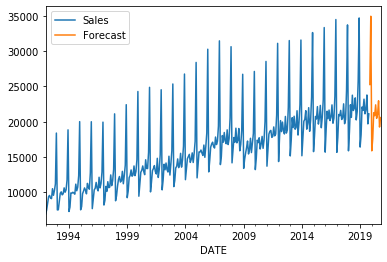

In [47]:
ax = df.plot()
forecast_df.plot(ax=ax)

### Zoomed in

(576, 611)

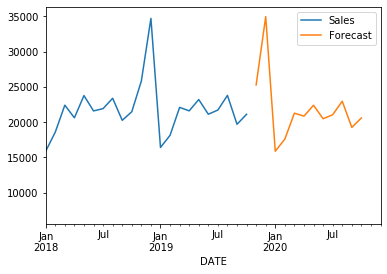

In [48]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')